In [1]:
import pandas as pd

pd.read_csv("parsed_admission/postgres_parsed.csv")

,log_time,session_id,session_line_num,virtual_transaction_id,transaction_id,query_template,query_params
0,2017-06-25 07:12:57.362167,4811356,0,AAC/4811356/0,NaN,NaN,()
1,2017-06-25 07:12:57.685996,4811357,0,AAC/4811357/0,NaN,NaN,()
2,2017-06-25 07:12:57.686190,4811357,1,AAC/4811357/1,NaN,NaN,()
3,2017-06-25 07:12:57.686832,4811357,2,AAC/4811357/2,NaN,"SELECT expdate,expdate2 FROM systemenv where d...","('1',)"
4,2017-06-25 07:12:57.695170,4811357,3,AAC/4811357/3,NaN,select content from content where name= $1 and...,"(""'15\\5d3afff71fda95c45e666b77095523a5'"", '1')"
5,2017-06-25 07:12:57.697223,4811357,4,AAC/4811357/4,NaN,NaN,()
6,2017-06-25 07:18:19.799453,4811358,0,AAC/4811358/0,NaN,NaN,()
7,2017-06-25 07:18:19.799775,4811358,1,AAC/4811358/1,NaN,NaN,()
8,2017-06-25 07:18:19.803895,4811358,2,AAC/4811358/2,NaN,SELECT programs.id FROM programs INNER JOIN lu...,"('1', '1')"
9,2017-06-25 07:18:19.804219,4811358,3,AAC/4811358/3,NaN,SELECT name from domain where id = $1,"('1',)"


In [1]:
import datetime
from typing import Dict

import numpy as np
import pandas as pd
import sklearn.metrics.pairwise
import sklearn.neighbors
import sklearn.preprocessing
from plumbum import cli
from sklearn.cluster import DBSCAN

from constants import DEBUG_POSTGRESQL_CSV_PARSED


class Clusterer:
    """
    Cluster query templates based on the algorithms from QueryBot5000.

    [QueryBot5000]
    Lin Ma, Dana Van Aken, Ahmed Hefny, Gustavo Mezerhane, Andrew Pavlo,
    and Geoffrey J. Gordon. 2018. Query-based Workload Forecasting for
    Self-Driving Database Management Systems. SIGMOD 2018.

    Attributes
    ----------
    _df : pd.Dataframe
        Dataframe of counts grouped by (template, log_time_s)
        where log_time_s is aggregated to the clustering_interval
    n_samples : int
        Number of samples to use for calculating similarity between arrival rates.
    rho : float
        Similarity threshold used to determine template cluster membership.
    min_time : pd.Timestamp
        Earliest timestamp seen in _df.
    max_time : pd.Timestamp
        Latest timestamp seen in _df.
    cluster_interval : pd.Timedelta
        Time interval the df is aggregated by.
    n : int
        Number of datapoints in _df.
    cluster_gap : int
        Only use every x "time steps" to iterate for online clustering.
    n_gaps : int
        Number of time steps to to run online clustering.
    _dbgname : dict (string:int)
        Reverse lookup from query template string to an id.
    """

    def __init__(
        self, dataframe, n_samples=10000, rho=0.8, cluster_interval=pd.Timedelta(seconds=1),
    ):
        """
        Cluster the provided dataframe according to QueryBot5000.

        Parameters
        ----------
        dataframe : pd.DataFrame
            Dataframe containing the query templates to be clustered.
        n_samples : int
            The number of timestamps to sample.
        rho : float
            Cosine similarity threshold for query template clustering.
        cluster_interval : pd.TimeDelta
            Time interval to group and count the query templates.
        """
        assert dataframe.index.names == ["query_template", "log_time_s"]
        assert dataframe.columns.values == ["count"]
        self._df = dataframe
        self.n_samples = n_samples
        self.rho = rho

        # Cluster interval of every second.
        self.min_time = self._get_timestamps().min()
        self.max_time = self._get_timestamps().max()

        self.interval_delta = cluster_interval
        self.n = int((self.max_time - self.min_time) / self.interval_delta + 1)

        self.cluster_gap = 1
        self.n_gaps = self.n // self.cluster_gap + 1

        # Represent query templates with integers for concise readability.
        self._dbgname = {
            template_str: template_id for template_id, template_str in dict(enumerate(self._get_queries())).items()
        }

        # Cluster the queries.
        self.assignment_df = self._cluster_offline()

    def _get_queries(self):
        """
        Get the query templates being clustered.

        Returns
        -------
        queries : List[str]
            A list of the query templates being clustered.
        """
        return sorted(set(self._df.index.get_level_values(0)))

    def _get_timestamps(self):
        """
        Get all the timestamps across all the query templates.

        Returns
        -------
        timestamps : pd.DatetimeIndex
            All the timestamps.
        """

        # TODO(Mike): Are we ever relying on the date time index here to
        # reconstruct the time series with the clustering interval?
        # Could anything go wrong if this only has
        # 00:00, 00:01, 00:03, 00:04, but missing 00:02?
        return self._df.index.get_level_values(1)

    def _get_first_arrival(self, template):
        """
        Find the first arrival time for the given query.

        Parameters
        ----------
        template : str
            The query template to find the first arrival time for.

        Returns
        -------
        first_arrival : pd.Timestamp
            The first timestamp for the given query template.
        """
        return self._df.xs(template, level=0).index.min()

    @staticmethod
    def _query_df_range(df, template, start_time, end_time):
        """

        Parameters
        ----------
        df
        template
        start_time
        end_time

        Returns
        -------
        results : pd.DataFrame
        """
        # The first level can be dropped since query_template == template.
        return df.query(
            "`query_template` == @template and @start_time <= `log_time_s` and `log_time_s` < @end_time"
        ).droplevel(0)

    @staticmethod
    def _query_df(df, template, timestamps):
        """
        Get template counts, sampled by timestamps

        Parameters
        ----------
        df
        template
        timestamps

        Returns
        -------
        results : pd.DataFrame
        """
        # The first level can be dropped since query_template == template.
        df = df.query("`query_template` == @template and `log_time_s` in @timestamps").droplevel(0)
        return df.reindex(timestamps, fill_value=0)

    @staticmethod
    def _query_series(series, timestamps):
        """
        Get values for a series, indexed by sample timestamps

        Parameters
        ----------
        series
        timestamps

        Returns
        -------
        results : pd.DataFrame
        """
        series = series.query("`log_time_s` in @timestamps")
        return series.reindex(timestamps, fill_value=0)

    @staticmethod
    def _similarity(s1, s2):
        """
        Compute the cosine similarity between the two series.
        Parameters
        ----------
        s1 : np.ndarray
        s2 : np.ndarray

        Returns
        -------
        similarity : np.float64
        """
        if s1.shape[0] == 0 or s2.shape[0] == 0:
            return 0
        # Reshape because we only have a single feature, the count.
        arr1 = s1.reshape(-1, 1)
        arr2 = s2.reshape(-1, 1)
        # Compute the cosine similarity.
        return sklearn.metrics.pairwise.cosine_similarity(arr1, arr2)[0][0]

    @staticmethod
    def _sample_timestamps(n, start_time, end_time, n_samples, interval):
        """

        Parameters
        ----------
        n : int
        start_time : pd.Timestamp
        end_time : pd.Timestamp
        n_samples : int
        interval : pd.TimeDelta

        Returns
        -------
        samples : pd.DatetimeArray
            Array of timestamps that were sampled.
        """
        if n > n_samples:
            offsets = np.random.choice(a=n, size=n_samples, replace=False)
        else:
            offsets = np.arange(n)
        timestamps = []
        for offset in offsets:
            next_time = start_time + interval * offset
            if next_time >= end_time:
                break
            timestamps.append(next_time)
        return pd.array(timestamps)

    @staticmethod
    def _build_neighbors(centers, timestamps, n_neighbors):
        """

        Parameters
        ----------
        centers
        timestamps
        n_neighbors

        Returns
        -------
        neighbors : sklearn.neighbors.NearestNeighbors | None
        """
        clusters = sorted(centers.keys())
        samples = np.array([Clusterer._query_series(centers[cluster], timestamps).values for cluster in clusters])

        if len(samples) == 0:
            neighbors = None
        else:
            samples = samples.reshape(len(clusters), -1)
            normalized_samples = sklearn.preprocessing.normalize(samples, copy=False)
            neighbors = sklearn.neighbors.NearestNeighbors(n_neighbors=n_neighbors, algorithm="kd_tree", metric="l2")
            neighbors.fit(normalized_samples)
        return neighbors

    def _modify_cluster(self, positive, cluster, template, start_time, end_time):
        """Add or remove a template from a cluster.

        Parameters
        ----------
        positive : bool
            True for add, False for remove.
        cluster : int
            The Cluster to modify.
        template : string
            Template to add to or remove from.
        start_time, end_time : pd.Timestamp
            Current time range considered
        """
        modify_method = self.centers[cluster].add if positive else self.centers[cluster].sub

        self.centers[cluster] = modify_method(
            self._query_df_range(self._df, template, start_time, end_time), fill_value=0
        )
        self.cluster_sizes[cluster] += 1 if positive else -1

    def _adjust_template(self, template, current_time, old_assignment, timestamps, neighbors):
        """Adjust template cluster assignment at current time.

        Parameters
        ----------
        template : string
            The query template we need to update.
        current_time : pd.Timestamp
            Timestamp of the current clustering iteration.
        old_assignment : int
            Template's previous cluster assignment.
        timestamps : np.array(pd.Timestamp)
            Array of timestamps to sample from the centers fo similarity measurement.
        neighbors : sklearn.neighbors.NearestNeighbors
            Nearest neighbor learner containing all the cluster centers.

        Returns
        -------
        The updated cluster assignment to be added to self.assignments.
        """
        end_time = current_time + self.cluster_gap * self.interval_delta
        # Only consider the last 10 seconds.
        start_time = max(self.min_time, end_time - datetime.timedelta(seconds=10))

        # If template has not appeared at this point in time; assignment is still None.
        if (old_assignment is None) and (current_time <= self._get_first_arrival(template)):
            return None
        if old_assignment is not None:
            # Template is the last member of the cluster.
            last_cluster_element = self.cluster_sizes[old_assignment] == 1
            # Template still belongs to its old cluster.
            still_belongs = (
                Clusterer._similarity(
                    self._query_df(self._df, template, timestamps).values,
                    self._query_series(self.centers[old_assignment], timestamps).values,
                )
                > self.rho
            )
            # If the template still belongs.
            if last_cluster_element or still_belongs:
                # reason = ('L' if last_cluster_element else '') + ('B' if still_belongs else '')
                # print(f'Template stayed in cluster {old_cluster} because ({reason}): {self._dbgname[template]}')
                return old_assignment

            # Otherwise, eliminate the template from its old cluster.
            self._modify_cluster(False, old_assignment, template, start_time, end_time)
            # print(f'Template eliminated from cluster {old_cluster}: {self._dbgname[template]}')

        new_assignment = None
        # Try to find a cluster membership for the template.
        if neighbors is None:
            for cluster in self.centers.keys():
                if (
                    self._similarity(
                        self._query_df(self._df, template, timestamps).values,
                        self._query_series(self.centers[cluster], timestamps).values,
                    )
                    > self.rho
                ):
                    new_assignment = cluster
                    break
        else:
            data = self._query_df(self._df, template, timestamps)["count"].values.reshape(1, -1)
            data = sklearn.preprocessing.normalize(data)
            neighbor = neighbors.kneighbors(data, return_distance=False)[0][0]
            clusters = sorted(self.centers.keys())
            if self._similarity(data, self.centers[clusters[neighbor]].values) > self.rho:
                new_assignment = clusters[neighbor]

        # If this template found a cluster to join, then make the assignment and continue.
        if new_assignment is not None:
            # description = 'joined' if old_assignment is None else 'reassigned to'
            # print(f'Template {description} cluster {new_cluster}: {self._dbgname[template]}')
            self._modify_cluster(True, new_assignment, template, start_time, end_time)
            return new_assignment

        # Otherwise, this template needs a new cluster. Make a new cluster.
        new_assignment = self.next_cluster
        self.next_cluster += 1

        self.centers[new_assignment] = self._query_df_range(self._df, template, start_time, end_time)
        assert self.centers[new_assignment].index.name == "log_time_s"
        assert self.centers[new_assignment].columns.values == ["count"]
        if self.centers[new_assignment].shape[0] == 0:
            print(
                f"WARNING: cluster {new_assignment} has no items."
                f"Does the following query appear within the lookback window:"
                f"{self._dbgname[template]}"
            )

        self.cluster_sizes[new_assignment] = 1
        self.cluster_totals[new_assignment] = 0
        print(f"Created cluster {new_assignment} based on template: {self._dbgname[template]}")
        return new_assignment

    def _cluster_online(self):
        # Map cluster id to df representing center of cluster.
        self.centers: Dict[int, pd.DataFrame] = {}
        self.cluster_totals: Dict[int, int] = {}
        self.cluster_sizes: Dict[int, int] = {}

        # Array representing the assignment of template to clusters at a given time.
        self.assignments = [(self.min_time, {template: None for template in sorted(self._get_queries())},)]

        # Begin at min time with no assignments.
        current_time = self.min_time

        # The next cluster id to use.
        self.next_cluster = 0

        for gap in range(self.n_gaps):
            # End time is the next interval.
            next_time = current_time + self.cluster_gap * self.interval_delta
            # Only consider the last 10 seconds.
            start_time = max(self.min_time, next_time - datetime.timedelta(seconds=10))
            # Timestamps to consider.
            timestamps = self._sample_timestamps(self.n, start_time, next_time, self.n_samples, self.interval_delta)

            # Get assignment dicts.
            last_assignment = self.assignments[-1][1]
            assignment = last_assignment.copy()

            # Update counts for all the assignments made in the past round.
            for template in last_assignment:
                old_assignment = last_assignment[template]
                if old_assignment is not None:
                    counts = self._query_df_range(self._df, template, current_time, next_time)
                    self.centers[old_assignment] = self.centers[old_assignment].add(counts, fill_value=0)
                    self.cluster_totals[old_assignment] += counts.sum().values[0]

            # If possible, build a kdtree of neighbors.
            neighbors = self._build_neighbors(self.centers, timestamps, n_neighbors=1)

            # For each template, try to assign a cluster.
            for template in self._get_queries():
                assignment[template] = self._adjust_template(
                    template=template,
                    current_time=current_time,
                    old_assignment=last_assignment[template],
                    timestamps=timestamps,
                    neighbors=neighbors,
                )

            # If possible, build an updated kdtree of neighbors. we need n_neighbors=2
            # because our query points are centers, so the second closest neighbor is the merge candidate.
            neighbors = self._build_neighbors(self.centers, timestamps, n_neighbors=2)
            root = [None] * len(self.centers)
            clusters = sorted(self.centers.keys())
            if len(clusters) > 1:
                # Try to merge clusters.
                for i, cluster in enumerate(clusters):
                    merge_cluster = None
                    data = self._query_series(self.centers[cluster], timestamps)["count"].values.reshape(1, -1)
                    data = sklearn.preprocessing.normalize(data)
                    neighbor = neighbors.kneighbors(data, return_distance=False)

                    neighbor_inds = neighbor[0]
                    if clusters[neighbor_inds[0]] == cluster:
                        neighbor = neighbor_inds[1]
                    else:
                        neighbor = neighbor_inds[0]
                    while root[neighbor] is not None:
                        neighbor = root[neighbor]
                    is_similar = (
                        self._similarity(
                            self._query_series(self.centers[cluster], timestamps).values,
                            self._query_series(self.centers[clusters[neighbor]], timestamps).values,
                        )
                        > self.rho
                    )
                    if cluster != clusters[neighbor] and is_similar:
                        merge_cluster = clusters[neighbor]
                    if merge_cluster is not None:
                        self.centers[merge_cluster] = self.centers[merge_cluster].add(
                            self.centers[cluster], fill_value=0
                        )
                        self.cluster_sizes[merge_cluster] += self.cluster_sizes[cluster]
                        del self.centers[cluster]
                        del self.cluster_sizes[cluster]
                        if neighbors is not None:
                            root[i] = neighbor
                        for template in self._get_queries():
                            if assignment[template] == cluster:
                                assignment[template] = merge_cluster
                                print(
                                    f"Template merged from cluster {cluster} into {merge_cluster}: "
                                    f"{self._dbgname[template]}"
                                )
            self.assignments.append((next_time, assignment))
            current_time = next_time
            for cluster, df in self.centers.items():
                if df.shape[0] == 0:
                    print(f"WARNING: gap {gap} cluster {cluster} has no items.")
        for template, cluster in self.assignments[-1][1].items():
            print(self._dbgname[template], "->", cluster)
        self.num_clusters = len(self.centers)

    def _cluster_offline(self):
        next_time = self.max_time + self.cluster_gap * self.interval_delta
        # TODO(Mike): only consider the last 10 seconds? or sample everything?
        start_time = self.min_time
        # Sample timestamps to consider.
        timestamps = self._sample_timestamps(self.n, start_time, next_time, self.n_samples, self.interval_delta)
        counts = np.array(
            [
                # Create (k,n) matrix where there are
                # k templates, n_sample features for DBSCAN.
                self._query_df(self._df, template, timestamps).values.reshape((-1))
                for template in self._get_queries()
            ]
        )

        clustering = DBSCAN(eps=1 - self.rho, metric="cosine", min_samples=1).fit(counts)
        labels = clustering.labels_
        reverse_lookup = {template_id: template_str for template_str, template_id in self._dbgname.items()}
        final_assignments = {reverse_lookup[template_id]: cluster_id for template_id, cluster_id in enumerate(labels)}
        return pd.DataFrame(final_assignments.items(), columns=["query_template", "cluster"]).set_index(
            "query_template"
        )


def get_grouped_dataframe_interval(df, interval=None):
    """
        Get the pre-grouped version of query log data.

        Parameters
        ----------
        interval : pd.TimeDelta or None
            time interval to group and count the query templates
            if None, pd is only aggregated by template

        Returns
        -------
        grouped_df : pd.DataFrame
            Dataframe containing the pre-grouped query log data.
            Grouped on query template and optionally log time.
        """
    gb = None
    if interval is None:
        gb = df.groupby("query_template").size()
        gb.drop("", axis=0, inplace=True)
    else:
        gb = df.groupby("query_template").resample(interval).size()
        # gb.drop("", axis=0, level=0, inplace=True)
    grouped_df = pd.DataFrame(gb, columns=["count"])
    return grouped_df


In [2]:
df = pd.read_csv(DEBUG_POSTGRESQL_CSV_PARSED, parse_dates=["log_time"], index_col=["log_time"])
cluster_interval = pd.Timedelta(milliseconds=250)

df = get_grouped_dataframe_interval(df, cluster_interval)

df.index.rename(["query_template", "log_time_s"], inplace=1)
print("Clustering query templates.")
clusterer = Clusterer(df, cluster_interval=cluster_interval)
print("Generating cluster assignments.")
clusterer.assignment_df[:20]
# clusterer.assignment_df.to_parquet(output_parquet)
# print("Done!")

# df[:20]

Clustering query templates.
Generating cluster assignments.


,cluster
query_template,
SELECT * FROM period_application WHERE period_id = $1,0
SELECT * FROM period_umbrella WHERE period_id = $1 LIMIT $2,0
SELECT department_unit.* FROM department_unit WHERE unit_id = $1,0
SELECT domain_unit.* FROM domain_unit WHERE domain_id = $1,0
SELECT domain_unit.* FROM domain_unit WHERE unit_id = $1,0
"SELECT expdate,expdate2 FROM systemenv where domain_id=$1",1
SELECT name from domain where id = $1,0
SELECT period.* FROM period WHERE period_id = $1 ORDER BY period_id DESC,0
SELECT period.* FROM period WHERE unit_id = $1 AND parent_period_id = $2 ORDER BY period_id DESC,0


In [ ]:
import csv
import glob
import re
from pathlib import Path

import numpy as np
import pandas as pd
from model import LSTM, ForecastDataset
from plumbum import cli
from preprocessor import Preprocessor


class ClusterForecaster:
    """
    Predict cluster in workload using trained LSTMs.

    Attributes
    ----------
    prediction_interval : pd.Timedelta
        Time interval to aggregate cluster counts by.
    prediction_horizon : pd.Timedelta
        The prediction horizon of the models to train.
    prediction_seqlen : int
        Number of intervals to feed the LSTM for a prediction.
    models : Dict[int, LSTM]
        Dictionary of trained models to perform inference by

    """

    MODEL_PREFIX = "model_"

    @staticmethod
    def cluster_to_file(path, cluster):
        """Generate model file path from cluster name"""
        return f"{path}/{ClusterForecaster.MODEL_PREFIX}{cluster}.pkl"

    @staticmethod
    def get_cluster_from_file(filename):
        """Infer cluster id from file name"""
        m = re.search(f"(?<={ClusterForecaster.MODEL_PREFIX})[^/]*(?=\\.pkl)", filename)
        if m is None:
            raise RuntimeError("Could not get cluster name")
        return m[0]

    def __init__(
        self,
        train_df,
        prediction_seqlen,
        prediction_interval,
        prediction_horizon,
        save_path,
        top_k=5,
        override=False,
    ):
        """Construct the ClusterForecaster object.
        Parameters
        ----------
        train_df : pd.DataFrame
            Training data grouped by cluster and timestamp
        save_path : str
            Directory for loading/saving trained models
        top_k : int
            Only train models for the top k most common clusters.
        override : bool
            Determines whether we should (re)train models anyway, even if they are
            in the directory.
        """
        assert train_df.index.names[0] == "cluster"
        assert train_df.index.names[1] == "log_time_s"

        self.prediction_seqlen = prediction_seqlen
        self.prediction_interval = prediction_interval
        self.prediction_horizon = prediction_horizon
        self.models = {}

        if not override:
            model_files = glob.glob(str(Path(save_path) / f"{self.MODEL_PREFIX}*.pkl"))
            for filename in model_files:
                cluster_name = self.get_cluster_from_file(filename)
                self.models[int(cluster_name)] = LSTM.load(filename)
                print(f"loaded model for cluster {cluster_name}")
            print(f"Loaded {len(model_files)} models")

        if train_df is None:
            return

        # Only consider top k clusters.
        cluster_totals = train_df.groupby(level=0).sum().sort_values(by="count", ascending=False)
        labels = cluster_totals.index[:top_k]

        print("Training on cluster time series..")

        mintime = train_df.index.get_level_values(1).min()
        maxtime = train_df.index.get_level_values(1).max()

        dtindex = pd.DatetimeIndex([mintime, maxtime])

        for cluster in labels:
            if cluster in self.models and not override:
                print(f"Already have model for cluster {cluster}, skipping")
                continue

            print(f"training model for cluster {cluster}")
            cluster_counts = train_df[train_df.index.get_level_values(0) == cluster].droplevel(0)

            # This zero-fills the start and ends of the cluster time series.
            cluster_counts = cluster_counts.reindex(cluster_counts.index.append(dtindex), fill_value=0)
            cluster_counts = cluster_counts.resample(prediction_interval).sum()
            self._train_cluster(cluster_counts, cluster, save_path)

    def _train_cluster(self, cluster_counts, cluster, save_path):
        dataset = ForecastDataset(
            cluster_counts,
            sequence_length=self.prediction_seqlen,
            horizon=self.prediction_horizon,
            interval=self.prediction_interval,
        )

        self.models[cluster] = LSTM(
            horizon=self.prediction_horizon,
            interval=self.prediction_interval,
            sequence_length=self.prediction_seqlen,
        )

        self.models[cluster].fit(dataset)
        self.models[cluster].save(self.cluster_to_file(save_path, cluster))

    def predict(self, cluster_df, cluster, start_time, end_time):
        """
        Given a cluster dataset, attempt to return prediction of query count
        from a cluster within the given time-range.
        """
        assert cluster_df.index.names[0] == "cluster"
        assert cluster_df.index.names[1] == "log_time_s"

        # Cluster not in the data.
        if cluster not in cluster_df.index.get_level_values(0):
            return None

        # No model for given cluster.
        if cluster not in self.models.keys():
            return None

        cluster_counts = cluster_df[cluster_df.index.get_level_values(0) == cluster].droplevel(0)

        # Truncate cluster_df to the time range necessary to generate prediction range.

        # TODO(Mike): Right now, if the sequence required to predict a certain interval
        # is not present in the data, we simply do not make any predictions (i.e. return 0)
        # Should we produce a warning/error so the user is aware there is insufficient
        # data?
        trunc_start = start_time - self.prediction_horizon - (self.prediction_seqlen) * self.prediction_interval
        trunc_end = end_time - self.prediction_horizon

        truncated = cluster_counts[(cluster_counts.index >= trunc_start) & (cluster_counts.index < trunc_end)]

        dataset = ForecastDataset(
            truncated,
            sequence_length=self.prediction_seqlen,
            horizon=self.prediction_horizon,
            interval=self.prediction_interval,
        )

        # generate predictions
        predictions = [self.models[cluster].predict(seq) for seq, _ in dataset]

        # tag with timestamps
        pred_arr = [[dataset.get_y_timestamp(i), pred] for i, pred in enumerate(predictions)]

        pred_df = pd.DataFrame(pred_arr, columns=["log_time_s", "count"])
        pred_df.set_index("log_time_s", inplace=True)
        return pred_df[start_time:]


class WorkloadGenerator:
    """
    Use preprocessed query template/params and cluster to generate
    representative workload.
    """

    def __init__(self, preprocessor, assignment_df):
        df = preprocessor.get_grouped_dataframe_interval()

        # Join to cluster and group by.
        joined = df.join(assignment_df)

        # Calculate weight of template within each cluster.
        joined["cluster"].fillna(-1, inplace=True)
        summed = joined.groupby(["cluster", "query_template"]).sum()
        self._preprocessor = preprocessor
        self._percentages = summed / summed.groupby(level=0).sum()

    def get_workload(self, cluster, cluster_count):
        """Given a cluster id and a sample size, produce a "sample" workload,
        sampling from the preprocessed queries.

        Parameters
        ----------
        cluster : int
            The cluster to generate for
        cluster_count : scalar
            The number of queries to sample

        Returns
        -------
        predicted_queries : pd.Dataframe
            A sampled workload in the form of (query, count) pairs
        """

        templates = self._percentages[self._percentages.index.get_level_values(0) == cluster].droplevel(0)
        templates = templates * cluster_count

        # TODO(Mike): The true sample of parameters might be too inefficient,
        # But using the same parameters for all queries is not representative enough.

        # True sample of parameters.
        # templates_with_param_vecs = [
        #     (template, self._preprocessor.sample_params(template, int(count)))
        #     for template, count in zip(templates.index.values, templates.values)
        # ]

        # Sample parameters once. Then use the same parameters
        # for all queries in the query template.
        templates_with_param_vecs = [
            (
                template,
                np.tile(self._preprocessor.sample_params(template, 1)[0], (int(count), 1)),
            )
            for template, count in zip(templates.index.values, templates.values)
        ]

        workload = [
            self._preprocessor.substitute_params(template, param_vec)
            for template, param_vecs in templates_with_param_vecs
            for param_vec in param_vecs
        ]
        workload = pd.DataFrame(workload, columns=["query"])
        predicted_queries = workload.groupby("query").size().sort_values(ascending=False)

        return predicted_queries
        

In [7]:
print("Loading postgres log...")
df = pd.read_csv(DEBUG_POSTGRESQL_CSV_PARSED, parse_dates=["log_time"], index_col=["log_time"])
cluster_interval = pd.Timedelta(milliseconds=250)
df = get_grouped_dataframe_interval(df, cluster_interval)

print("reading cluster assignments.")
assignment_df = clusterer.assignment_df

# Join to cluster and group by (cluster,time).
joined = df.join(assignment_df)
joined["cluster"].fillna(-1, inplace=True)
clustered_df = joined.groupby(["cluster", "log_time"]).sum()

clustered_df


# TODO(MIKE): check how many templates are not part of known
# clusters (i.e. cluster = -1).
# forecaster = ClusterForecaster(
#     clustered_df,
#     prediction_seqlen=self.pred_seqlen,
#     prediction_interval=self.pred_interval,
#     prediction_horizon=self.pred_horizon,
#     save_path=self.model_path,
#     override=self.override,
# )

# # Use preprocessor to sample template and parameter distributions.
# wg = WorkloadGenerator(preprocessor, assignment_df)
# clusters = set(assignment_df["cluster"].values)

# cluster_predictions = []
# for cluster in clusters:
#     start_time = pd.Timestamp(self.start_ts)
#     end_time = pd.Timestamp(self.end_ts)
#     pred_df = forecaster.predict(clustered_df, cluster, start_time, end_time)
#     if pred_df is None:
#         # No data or model for cluster.
#         continue
#     prediction_count = pred_df["count"].sum()
#     print(f"Prediction for {cluster}: {prediction_count}")
#     cluster_predictions.append(wg.get_workload(cluster, prediction_count))

# predicted_queries = pd.concat(cluster_predictions)
# predicted_queries.to_csv(self.output_csv, header=None, quoting=csv.QUOTE_ALL)


Loading postgres log...
reading cluster assignments.


count
cluster log_time                      
0       2017-06-25 07:18:33.750      5
        2017-06-25 07:18:34.000      0
        2017-06-25 07:18:34.250      0
        2017-06-25 07:18:34.500      0
        2017-06-25 07:18:34.750      5
        2017-06-25 07:18:35.000      0
        2017-06-25 07:18:35.250      0
        2017-06-25 07:18:35.500      0
        2017-06-25 07:18:35.750      3
1       2017-06-25 07:18:29.750      1
2       2017-06-25 07:18:23.750      1
3       2017-06-25 07:18:28.750      1
4       2017-06-25 07:18:19.750      1
        2017-06-25 07:18:20.000      0
        2017-06-25 07:18:20.250      0
        2017-06-25 07:18:20.500      0
        2017-06-25 07:18:20.750      1
5       2017-06-25 07:18:32.750      1
        2017-06-25 07:18:33.000      0
        2017-06-25 07:18:33.250      0
        2017-06-25 07:18:33.500      0
        2017-06-25 07:18:33.750      1
        2017-06-25 07:18:34.000      0
        2017-06-25 07:18:34.250      0
        2017-06-25 07:18:34.500      0
        2017-06-25 07:18:34.750      0
        2017-06-25 07:18:35.000      0
        2017-06-25 07:18:35.250      0
        2017-06-25 07:18:35.500      0
        2017-06-25 07:18:35.750      1
6       2017-06-25 07:18:31.750      1
7       2017-06-25 07:18:25.750      1
8       2017-06-25 07:18:30.750      1
9       2017-06-25 07:18:27.750      1
10      2017-06-25 07:18:24.750      1

In [5]:
import torch
import numpy as np
import torch.nn as nn
from tqdm import tqdm
import pandas as pd
from scipy import stats
import joypy
import matplotlib.pyplot as plt

import pickle
import os
import warnings
import random

from param_preprocessor import DataPreprocessor

from sklearn.model_selection import train_test_split

# LSTM config
HIDDEN_SIZE = 128
RNN_LAYERS = 2
EPOCHS = 50
LR = 0.0001
device = "cuda" if torch.cuda.is_available() else "cpu"

# Constants
PREPROCESSOR_SAVE_PATH = "./data/data_preprocessor.pickle"
MODEL_SAVE_PATH = "./models/1m1p/"
qt_to_param_X_SAVE_PATH = "./data/qt_to_param_X.pickle"
qt_to_param_Y_SAVE_PATH = "./data/qt_to_param_Y.pickle"
qt_to_param_quantile_timeseries_SAVE_PATH = "./data/qt_to_param_quantile_timeseries.pickle"
qt_to_index_SAVE_PATH = "./data/qt_to_index.pickle"


class QuantileMetadata:
    def left_boundary(x):
        return x.quantile(0.01)

    def q1(x):
        return x.quantile(0.1)

    def q2(x):
        return x.quantile(0.2)

    def q3(x):
        return x.quantile(0.3)

    def q4(x):
        return x.quantile(0.4)

    def q5(x):
        return x.quantile(0.5)

    def q6(x):
        return x.quantile(0.6)

    def q7(x):
        return x.quantile(0.7)

    def q8(x):
        return x.quantile(0.8)

    def q9(x):
        return x.quantile(0.9)

    def right_boundary(x):
        return x.quantile(0.99)


class ParamQuantileData:
    """ 
    Contains train and test data for certain parameter
    """

    def __init__(self, X_train, X_test, Y_train, Y_test):
        self.X_train = X_train
        self.X_test = X_test
        self.Y_train = Y_train
        self.Y_test = Y_test

    def get_train_test_data(self):
        return self.X_train, self.X_test, self.Y_train, self.Y_test


class QueryQuantileData:
    """
    Contains train/test data for all parameters
    """

    def __init__(self, query_template, all_param_quantile_data):
        self.query_template = query_template
        self.param_quantile_data = all_param_quantile_data


class Network(nn.Module):
    def __init__(self, input_size, output_size, hidden_size=HIDDEN_SIZE, num_layers=RNN_LAYERS):
        super(Network, self).__init__()

        self.lstm = nn.LSTM(
            input_size=input_size, hidden_size=hidden_size, num_layers=num_layers, bidirectional=False, dropout=0.1
        )
        self.classification = nn.Sequential(
            nn.Linear(in_features=hidden_size, out_features=64),
            nn.LeakyReLU(),
            nn.Linear(in_features=64, out_features=output_size),
        )

    def forward(self, x):
        output, (h_n, c_n) = self.lstm(x)
        # output: (L, 1 * H_out)

        out = self.classification(output)
        return out


class Forecaster:
    def __init__(
        self, pred_interval=pd.Timedelta("2S"), pred_seq_len=5, pred_horizon=pd.Timedelta("2S"), load_metadata=False
    ):

        # Quantiles to be used to generate training data
        self.quantiles = [
            QuantileMetadata.left_boundary,
            QuantileMetadata.q1,
            QuantileMetadata.q2,
            QuantileMetadata.q3,
            QuantileMetadata.q4,
            QuantileMetadata.q5,
            QuantileMetadata.q6,
            QuantileMetadata.q7,
            QuantileMetadata.q8,
            QuantileMetadata.q9,
            QuantileMetadata.right_boundary,
        ]
        self.quantile_names = [0, 10, 20, 30, 40, 50, 60, 70, 80, 90, 100]

        # Load DataPreprocessor class
        if load_metadata:
            with open(PREPROCESSOR_SAVE_PATH, "rb") as f:
                self.data_preprocessor = pickle.load(f)
        else:
            self.data_preprocessor = DataPreprocessor(pred_interval, pred_seq_len, pred_horizon)

        # Prediction interval hyperparameters
        self.prediction_interval = pred_interval  # Each interval has two seconds
        self.prediction_seq_len = pred_seq_len  # 5 data points
        self.prediction_horizon = pred_horizon  # total time = interval * seq_len

        self.qt_to_param_X = {}
        self.qt_to_param_Y = {}
        self.qt_to_param_quantile_timeseries = {}
        self.qt_to_index = {}

        if load_metadata:
            self.load_forecast_metadata()

    def _generate_param_X_Y_dict(self):
        """qt_to_param_X: 
        key = query template
        value = [param1_quantile_df, param2_quantile_df, ...]
        """
        with warnings.catch_warnings():
            warnings.simplefilter("ignore")
            # X has shape (N, seq_len, num_quantiles) --> each training instance
            # has shape (seq_len, num_quantiles)
            # Y has shape (N, num_quantiles)
            query_to_param_X = {}
            query_to_param_Y = {}
            for qt, tdfp in tqdm(self.data_preprocessor.qt_to_normalized_df.items()):
                param_X = []
                param_Y = []

                dtypes = self.data_preprocessor.qt_to_dtype[qt]
                for j, col in enumerate(tdfp):
                    # Skip non-numerical columns
                    if dtypes[j] == "string":
                        param_X.append(None)
                        param_Y.append(None)
                        continue

                    param_col_X = []
                    param_col_Y = []
                    # Group by time and get quantile data
                    time_series_df = tdfp[col].resample(self.prediction_interval).agg(self.quantiles)
                    time_series_df = time_series_df.astype(float)
                    # display(time_series_df.head())
                    shifted = time_series_df.shift(freq=-self.prediction_horizon).reindex_like(time_series_df).ffill()

                    # Generate training instance. Add padding if neccesary
                    for i in range(len(time_series_df) - 1):
                        if i + 1 >= self.prediction_seq_len:
                            i_start = i - self.prediction_seq_len + 1
                            param_col_X.append(time_series_df.iloc[i_start : (i + 1), :].to_numpy())
                            param_col_Y.append(shifted.iloc[i, :].to_numpy())
                        else:
                            x = time_series_df.iloc[: (i + 1), :].to_numpy()
                            # Add padding above the rows
                            x = np.pad(x, ((self.prediction_seq_len - i - 1, 0), (0, 0)))
                            param_col_X.append(x)
                            param_col_Y.append(shifted.iloc[i, :].to_numpy())
                    param_col_X, param_col_Y = np.asarray(param_col_X), np.asarray(param_col_Y)
                    param_X.append(param_col_X)
                    param_Y.append(param_col_Y)

                query_to_param_X[qt] = param_X
                query_to_param_Y[qt] = param_Y
            self.qt_to_param_X = query_to_param_X
            self.qt_to_param_Y = query_to_param_Y

    def generate_time_series_data(self):
        """qt_to_param_quantile_timeseries:
        key = query template
        value = [(param1_X_train, param1_X_test, param1_Y_train, param1_Y_test), (param2...), ...]
        """
        self._generate_param_X_Y_dict()
        self.qt_to_param_quantile_timeseries = {}
        for qt in tqdm(self.qt_to_param_X.keys()):
            param_X = self.qt_to_param_X[qt]
            param_Y = self.qt_to_param_Y[qt]

            param_quantile_timeseries = []
            for i in range(len(param_X)):
                # Skip string parameter
                if self.data_preprocessor.qt_to_dtype[qt][i] == "string":
                    param_quantile_timeseries.append(None)
                    continue

                param_col_X = param_X[i]
                param_col_Y = param_Y[i]

                # Split into train test set
                X_train, X_test, Y_train, Y_test = train_test_split(
                    param_col_X, param_col_Y, shuffle=False, test_size=0.1
                )
                # Train on all data. TODO: This is just a hack right now to split
                # data into two portions. However, we still want to train on
                # all data.
                X_train, Y_train = param_col_X, param_col_Y

                # X: (N, L, H_in) to (L, N, H_in);
                X_train, X_test = np.transpose(X_train, (1, 0, 2)), np.transpose(X_test, (1, 0, 2))
                # print(X_train.shape, X_test.shape, Y_train.shape, Y_test.shape)
                param_quantile_timeseries.append(ParamQuantileData(X_train, X_test, Y_train, Y_test))

            self.qt_to_param_quantile_timeseries[qt] = QueryQuantileData(qt, param_quantile_timeseries)
        # print(
        #     self.qt_to_param_quantile_timeseries[
        #         "DELETE FROM new_order WHERE NO_O_ID = $1 AND NO_D_ID = $2 AND NO_W_ID = $3"
        #     ]
        #     .param_quantile_data[0]
        #     .X_train.shape
        # )

    def save_checkpoint(self, ckpt_path, filename, query_template, model, epoch, optimizer=None, scheduler=None):
        path = os.path.join(ckpt_path, f"{filename}")

        if not os.path.exists(ckpt_path):
            os.makedirs(ckpt_path)

        save_dict = {
            "model_state": model.state_dict(),
            "epoch": epoch,
            "qt": query_template,
        }

        if optimizer != None:
            save_dict["optimizer_state"] = optimizer.state_dict()
        if scheduler != None:
            save_dict["scheduler_state"] = scheduler.state_dict()

        torch.save(save_dict, path)
        # print(f"=> saved the model {filename} to {path}")

    def export_forecast_metadata(self):
        with open(qt_to_index_SAVE_PATH, "wb") as f:
            pickle.dump(self.qt_to_index, f)

        with open(qt_to_param_quantile_timeseries_SAVE_PATH, "wb") as f:
            pickle.dump(self.qt_to_param_quantile_timeseries, f)

        with open(qt_to_param_X_SAVE_PATH, "wb") as f:
            pickle.dump(self.qt_to_param_X, f)

        with open(qt_to_param_Y_SAVE_PATH, "wb") as f:
            pickle.dump(self.qt_to_param_Y, f)

    def load_forecast_metadata(self):
        with open(qt_to_index_SAVE_PATH, "rb") as f:
            self.qt_to_index = pickle.load(f)

        with open(qt_to_param_quantile_timeseries_SAVE_PATH, "rb") as f:
            self.qt_to_param_quantile_timeseries = pickle.load(f)

        with open(qt_to_param_X_SAVE_PATH, "rb") as f:
            self.qt_to_param_X = pickle.load(f)

        with open(qt_to_param_Y_SAVE_PATH, "rb") as f:
            self.qt_to_param_Y = pickle.load(f)

    ###################################################################################################
    #########################           Model Training        #########################################
    ###################################################################################################
    def _train_epoch(self, model, X_train, Y_train, optimizer, scheduler, loss_function):
        model.train()

        # Shuffle the timeseries
        arr = np.arange(X_train.shape[1])
        np.random.shuffle(arr)

        train_loss = 0
        batch_bar = tqdm(total=X_train.shape[1], dynamic_ncols=True, leave=False, position=0, desc="Train")
        for ind in arr:
            seq = torch.tensor(X_train[:, ind : ind + 1, :]).to(device).float()
            labels = torch.tensor(Y_train[ind]).to(device).float()
            optimizer.zero_grad()
            y_pred = model(seq)
            single_loss = loss_function(y_pred[-1, -1, :], labels)
            single_loss.backward()
            optimizer.step()
            scheduler.step()
            train_loss += float(single_loss)

            batch_bar.set_postfix(
                loss="{:.04f}".format(float(train_loss / (ind + 1))),
                lr="{:.04f}".format(float(optimizer.param_groups[0]["lr"])),
            )

            batch_bar.update()

        train_loss /= X_train.shape[1]
        batch_bar.close()
        return train_loss

    def _validate(self, model, X_test, Y_test, loss_function):
        # Validation loss
        model.eval()
        val_loss = 0
        batch_bar = tqdm(total=X_test.shape[1], dynamic_ncols=True, leave=False, position=0, desc="Validate")
        for ind in range(X_test.shape[1]):
            seq = torch.tensor(X_test[:, ind : ind + 1, :]).to(device).float()
            labels = torch.tensor(Y_test[ind]).to(device).float()

            with torch.no_grad():
                y_pred = model(seq)

            single_loss = loss_function(y_pred[-1, -1, :], labels)
            val_loss += float(single_loss)
            batch_bar.update()
        val_loss /= X_test.shape[1]
        batch_bar.close()
        return val_loss

    def _train_model(self):
        self.qt_to_index = {}
        for template_index, (qt, query_quantile_data_obj) in enumerate(self.qt_to_param_quantile_timeseries.items()):
            self.qt_to_index[qt] = template_index
            for param_index, param_quantile_data_obj in enumerate(query_quantile_data_obj.param_quantile_data):
                print(f"Training for Q{template_index}-P{param_index}...")

                # Skip string param
                if param_quantile_data_obj == None:
                    continue

                X_train, X_test, Y_train, Y_test = param_quantile_data_obj.get_train_test_data()

                model = Network(len(self.quantiles), len(self.quantiles), HIDDEN_SIZE, RNN_LAYERS).to(device)
                loss_function = nn.MSELoss()
                optimizer = torch.optim.Adam(model.parameters(), lr=LR)
                scheduler = torch.optim.lr_scheduler.CosineAnnealingLR(optimizer, T_max=(X_train.shape[1] * EPOCHS))

                for epoch in range(EPOCHS):
                    train_loss = self._train_epoch(model, X_train, Y_train, optimizer, scheduler, loss_function)
                    val_loss = self._validate(model, X_test, Y_test, loss_function)

                # print(f"[LSTM FIT]epoch: {epoch + 1:3}, train_loss: {train_loss:10.8f}, val_loss: {val_loss:10.8f}")
                filename = f"{template_index}_{param_index}"
                self.save_checkpoint(MODEL_SAVE_PATH, filename, qt, model, epoch)

    def fit(self, log_filename, file_type="parquet", dataframe=None, save_metadata=True):
        print("Preprocessing data...")
        self.data_preprocessor.preprocess(log_filename, file_type, dataframe)
        print("Preprocessing Done!")
        if save_metadata:
            self.data_preprocessor.save_to_file(PREPROCESSOR_SAVE_PATH)

        print("Generating training data...")
        self.generate_time_series_data()
        print("Data generation done!")

        self._train_model()

        if save_metadata:
            self.export_forecast_metadata()

    # Get all parameters for a query and compare it with actual data
    def get_all_parameters_for(self, query_template: str):
        template_original_df = self.data_preprocessor.qt_to_original_df[query_template]
        template_normalized_df = self.data_preprocessor.qt_to_normalized_df[query_template]
        template_dtypes = self.data_preprocessor.qt_to_dtype[query_template]
        template_stats = self.data_preprocessor.qt_to_stats[query_template]
        template_index = self.qt_to_index[query_template]

        for i, col in enumerate(template_normalized_df):
            # print(f"Processing parameter {i+1}...")
            # Skip non-numerical columns
            if template_dtypes[i] == "string":
                continue

            # Get corresponding model
            model = Network(len(self.quantiles), len(self.quantiles), HIDDEN_SIZE, RNN_LAYERS)
            filepath = os.path.join(MODEL_SAVE_PATH, f"{template_index}_{i}")
            state_dict = torch.load(filepath)
            model.load_state_dict(state_dict["model_state"])

            # Group by pred_iterval and get quantile data
            time_series_df = template_normalized_df[col].resample(self.prediction_interval).agg(self.quantiles)
            time_series_df = time_series_df.astype(float)

            # Get number of queries in each time interval
            num_template_df = template_normalized_df[col].resample(self.prediction_interval).count()
            # display(num_template_df.head())
            # display(time_series_df.head(10))

            # Build a new dataframe whichcontains predicted parameters for all timestamps
            generated_params = np.array([])
            num_queries_each_bin = 10
            timestamps = []
            for j in tqdm(range(len(time_series_df) - 1)):
                # Generate sequence data. Add padding if neccesary
                if j + 1 >= self.prediction_seq_len:
                    start_time = j - self.prediction_seq_len + 1
                    seq = time_series_df.iloc[start_time : (j + 1), :].to_numpy()
                else:
                    seq = time_series_df.iloc[: (j + 1), :].to_numpy()
                    seq = np.pad(seq, ((self.prediction_seq_len - j - 1, 0), (0, 0)))

                # Get predicted quantiles from the model
                seq = seq[None, :, :]
                seq = np.transpose(seq, (1, 0, 2))
                seq = torch.tensor(seq).to(device).float()
                with torch.no_grad():
                    pred = model(seq)

                # Ensure prediction quantile values are strictly increasing
                pred = pred[-1, -1, :]
                pred = torch.cummax(pred, dim=0).values

                # Generate num_template samples according to the distribution defined by the predicted quantile values
                pred = pred.cpu().detach().numpy()
                # print("pred:", pred)
                # print("actual:", time_series_df.iloc[j+1, :].to_numpy())
                # Un-normalize the quantiles
                mean, std = template_stats[i]
                if std != 0:
                    pred = pred * std + mean
                else:
                    pred = pred + mean

                # Draw (0.1*num_queries) samples from each bin of the predicted quantile
                for k in range(len(pred) - 1):
                    a, b = pred[k], pred[k + 1]
                    generated_params = np.concatenate(
                        [generated_params, np.random.uniform(a, b, num_queries_each_bin).astype(int)]
                    )
                    for _ in range(num_queries_each_bin):
                        timestamps.append(num_template_df.index[j + 1])

                # class Dist(stats.rv_continuous):
                #     def _cdf(self, x):
                #         conditions = [x <= pred[0]]
                #         for k in range(pred.shape[0] - 1):
                #             conditions.append(pred[k] <= x <= pred[k + 1])
                #         choices = [quantile_name / 100 for quantile_name in self.quantile_names]
                #         return np.select(conditions, choices, default=0)

                # dist = Dist(a=pred[0], b=pred[-1], name="deterministic")
                # # Model takes in sequence data until time j and ouputs prediction value for time j+1.
                # # Therefore we need the number of queries in thej+1's interval
                # # num_templates = int(num_template_df[j+1]/10) # Divide by 10 so it runs faster
                # num_params = 30  # Generate 30 parameter values for this specific parameter

                # try:
                #     for _ in range(num_params):
                #         generated_params.append(int(dist.rvs()))
                #         timestamps.append(num_template_df.index[j + 1])
                # except:
                #     # If all predicted quantiles have the same value, then a continous cdf cannot be constructed.
                #     # Just take any predicted quantile value as the prediction.
                #     for _ in range(num_params):
                #         generated_params.append(pred[0])
                #         timestamps.append(num_template_df.index[j + 1])

            # Generate a dataframe for the predicted parameter values
            predicted_params_df = pd.DataFrame(generated_params, index=pd.DatetimeIndex(timestamps))

            # Graph the results
            min_val, max_val = template_original_df[col].min(), template_original_df[col].max()
            min_val = min_val - (1 + 0.2 * (max_val - min_val))
            max_val = max_val + (1 + 0.2 * (max_val - min_val))

            print(f"PARAM ${i+1} Predicted")
            fig, axes = joypy.joyplot(
                predicted_params_df.groupby(pd.Grouper(freq="5s")),
                hist=True,
                bins=20,
                overlap=0,
                grid=True,
                x_range=[min_val, max_val],
            )
            plt.show()

            print(f"PARAM ${i+1} Actual")
            fig, axes2 = joypy.joyplot(
                template_original_df[col].to_frame().groupby(pd.Grouper(freq="5s")),
                hist=True,
                bins=20,
                overlap=0,
                grid=True,
                x_range=[min_val, max_val],
            )
            plt.show()
            print("\n")

    # Get all parameters for a query and compare it with actual data
    def get_parameters_for(self, query_template, timestamp, num_queries):
        target_timestamp = pd.Timestamp(timestamp)
        template_normalized_df = self.data_preprocessor.qt_to_normalized_df[query_template]
        template_dtypes = self.data_preprocessor.qt_to_dtype[query_template]
        template_stats = self.data_preprocessor.qt_to_stats[query_template]
        template_index = self.qt_to_index[query_template]
        param_X = self.qt_to_param_X[query_template]
        num_params = len(template_dtypes)

        # Draw (0.1*num_queries) samples from each bin of the predicted quantile
        generated_params = np.array([])
        num_queries_each_bin = int(num_queries / (len(self.quantiles) - 1))
        num_queries_last_bin = num_queries % (len(self.quantiles) - 1)  # Left over items in last bin

        for i in range(num_params):
            if template_dtypes[i] == "string":
                print("Skipping string columns")
                continue

            # Get corresponding model
            model = Network(len(self.quantiles), len(self.quantiles), HIDDEN_SIZE, RNN_LAYERS)
            filepath = os.path.join(MODEL_SAVE_PATH, f"{template_index}_{i}")
            state_dict = torch.load(filepath)
            model.load_state_dict(state_dict["model_state"])

            # Compute how many predictions need to be made
            start_timestamp = template_normalized_df.index.max()
            num_predictions = int((target_timestamp - start_timestamp) / self.prediction_interval)

            # Continously make predictions until target_timestamp
            param_X_col = param_X[i]
            seq = param_X_col[-1]
            seq = seq[None, :, :]
            seq = np.transpose(seq, (1, 0, 2))
            seq = torch.tensor(seq).to(device).float()
            for j in tqdm(range(num_predictions)):
                # Get predicted quantiles from the model
                with torch.no_grad():
                    pred = model(seq)

                # Ensure prediction quantile values are strictly increasing
                pred = pred[-1, -1, :]
                pred = torch.cummax(pred, dim=0).values

                # Add pred to original seq to create new seq for next time stamp
                seq = torch.squeeze(seq, axis=1)
                seq = torch.cat((seq[1:, :], pred[None, :]), axis=0)
                seq = seq[:, None, :]

            pred = pred.cpu().detach().numpy()

            # Un-normalize the quantiles
            mean, std = template_stats[i]
            if std != 0:
                pred = pred * std + mean
            else:
                pred = pred + mean

            # Draw (0.1*num_queries) samples from each bin of the predicted quantile
            for k in range(len(pred) - 1):
                a, b = pred[k], pred[k + 1]
                if j == len(pred) - 2:
                    generated_params = np.concatenate(
                        [generated_params, np.random.uniform(a, b, num_queries_last_bin)]
                    )
                else:
                    generated_params = np.concatenate(
                        [generated_params, np.random.uniform(a, b, num_queries_each_bin)]
                    )

            # class Dist(stats.rv_continuous):
            #     def _cdf(self_dist, x):  # Rename self to self_dist so that self refers to outer class
            #         conditions = [x <= pred[0]]
            #         for k in range(pred.shape[0] - 1):
            #             conditions.append(pred[k] <= x <= pred[k + 1])
            #         choices = [quantile_name / 100 for quantile_name in self.quantile_names]
            #         return np.select(conditions, choices, default=0)

            # dist = Dist(a=pred[0], b=pred[-1], name="deterministic")
            # # Model takes in sequence data until time j and ouputs prediction value for time j+1.
            # # Therefore we need the number of queries in the j+1's interval
            # generated_param_ith = []
            # try:
            #     for _ in range(num_queries):
            #         generated_param_ith.append(dist.rvs())
            # except:
            #     # If all predicted quantiles have the same value, then a continous cdf cannot be constructed.
            #     # Just take any predicted quantile value as the prediction.
            #     for _ in range(num_queries):
            #         generated_param_ith.append(pred[0])

            # generated_params.append(generated_param_ith)
        return generated_params
    

100%|██████████| 29/29 [00:00<00:00, 297.51it/s]


PARAM $1 Predicted


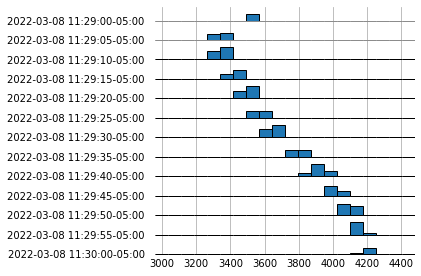

PARAM $1 Actual


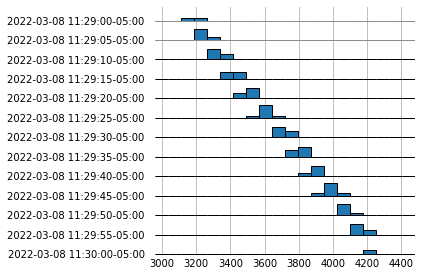

100%|██████████| 29/29 [00:00<00:00, 276.49it/s]


PARAM $2 Predicted


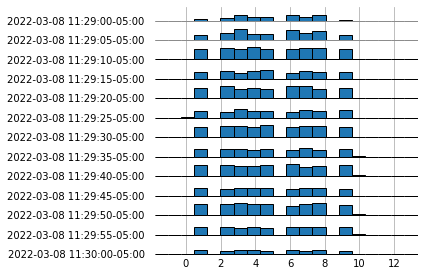

PARAM $2 Actual


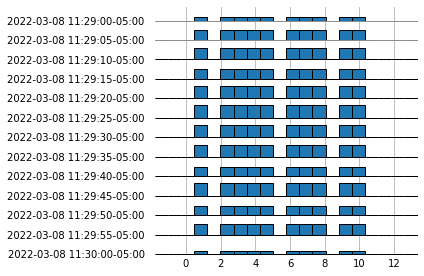

100%|██████████| 29/29 [00:00<00:00, 298.23it/s]


PARAM $3 Predicted


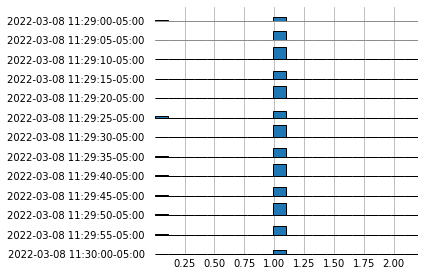

PARAM $3 Actual


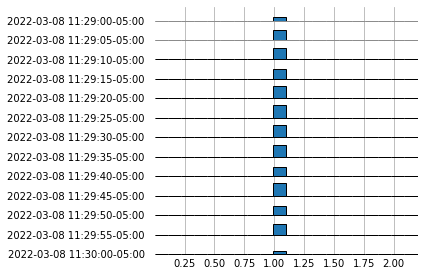

In [6]:
query_log_filename = "./preprocessed.parquet.gzip"

    # forecaster = Forecaster(
    #     pred_interval=pd.Timedelta("2S"), pred_seq_len=5, pred_horizon=pd.Timedelta("2S"), load_metadata=False
    # )
    # forecaster.fit(query_log_filename)

forecaster = Forecaster(
    pred_interval=pd.Timedelta("2S"), pred_seq_len=5, pred_horizon=pd.Timedelta("2S"), load_metadata=True
)
# pred_result = forecaster.get_parameters_for(
#     "DELETE FROM new_order WHERE NO_O_ID = $1 AND NO_D_ID = $2 AND NO_W_ID = $3",
#     "2022-03-08 11:30:06.021000-0500",
#     30,
# )
# print(pred_result)
forecaster.get_all_parameters_for("DELETE FROM new_order WHERE NO_O_ID = $1 AND NO_D_ID = $2 AND NO_W_ID = $3")

